This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False
    country_num = 10

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 28.8 MB/s 
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

In [ ]:
countries = train['country'].value_counts()
major_countries = countries[countries > CFG.country_num].index
major_countries

Index(['US', 'TR', 'ID', 'JP', 'TH', 'RU', 'BR', 'MY', 'BE', 'GB',
       ...
       'CM', 'AG', 'MW', 'VC', 'VA', 'RW', 'DM', 'CV', 'SX', 'CD'],
      dtype='object', length=176)

In [ ]:
mean_latlon = train[train['country'].isin(major_countries)].groupby('country')[['latitude', 'longitude']].mean().apply(lambda x: tuple(x), axis = 1).to_dict()
mean_latlon

{'AD': (42.545859185636466, 1.5623949169263895),
 'AE': (25.031196156825867, 55.125843416026626),
 'AF': (33.83802625734884, 66.24355789971725),
 'AG': (17.064483743894495, -61.8103130873108),
 'AL': (41.16438043034689, 19.412328749941274),
 'AM': (40.226330254579786, 44.639090877452354),
 'AO': (-8.889374849019317, 13.202976589291133),
 'AQ': (-69.60762211178053, -13.85584018293251),
 'AR': (-34.3017973185889, -59.675176940818325),
 'AT': (47.82784149912836, 14.668674401181589),
 'AU': (-33.60605387334255, 145.81505022396252),
 'AW': (12.538799105310463, -70.0247308418892),
 'AX': (59.189586941545805, 18.925737862902142),
 'AZ': (40.3754732198509, 49.74492239537704),
 'BA': (43.94847201899628, 18.204256543029196),
 'BB': (13.108549846295455, -59.59389100581457),
 'BD': (23.832095040888664, 89.78014903512299),
 'BE': (50.98628567649715, 4.058717644388699),
 'BG': (42.641392575674466, 24.688713330227394),
 'BH': (26.24331108929355, 50.43609293011559),
 'BL': (17.904371494236624, -62.841

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def correct_country(latlon):
    min_distance = float('inf')
    min_country = None
    for country in major_countries:
        distance = haversine(latlon, mean_latlon[country])
        if distance < min_distance:
            min_distance = distance
            min_country = country
    return min_country
train['new_country'] = train[['latitude', 'longitude']].apply(correct_country, axis = 1)
test['new_country'] = test[['latitude', 'longitude']].apply(correct_country, axis = 1)
print('Concordance rate: ' + str((train['country'] == train['new_country']).mean()))
train.head()

Concordance rate: 0.7032521610239443


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,new_country
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,BE
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,BR
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,TH
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,TR
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,ES


# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("new_country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories
0,E_0014dae22ccd6b,shôko restaurant,41.385287,2.197004,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ES,nan,...,E_0014dae22ccd6b,shôko restaurant,"pg. marítim de la barceloneta, 38",barcelona,nan,nan,ad,nan,nan,japanese restaurants


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

In [ ]:
train = train.drop(columns=['latitude', 'longitude', 'country'])
test = test.drop(columns=['latitude', 'longitude', 'country'])

In [ ]:
train_ = train.copy()
test_ = test.copy()
train_[['id', 'name', 'address', 'city', 'state', 'zip', 'new_country', 'url', 'phone', 'categories', 'point_of_interest'] + ['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_new_country', 'near_url', 'near_phone', 'near_categories', 'near_target']] = train_[['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_new_country', 'near_url', 'near_phone', 'near_categories', 'near_target'] + ['id', 'name', 'address', 'city', 'state', 'zip', 'new_country', 'url', 'phone', 'categories', 'point_of_interest']]
test_[['id', 'name', 'address', 'city', 'state', 'zip', 'new_country', 'url', 'phone', 'categories', 'point_of_interest'] + ['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_new_country', 'near_url', 'near_phone', 'near_categories', 'near_target']] = test_[['near_id', 'near_name', 'near_address', 'near_city', 'near_state', 'near_zip', 'near_new_country', 'near_url', 'near_phone', 'near_categories', 'near_target'] + ['id', 'name', 'address', 'city', 'state', 'zip', 'new_country', 'url', 'phone', 'categories', 'point_of_interest']]

In [ ]:
train = pd.concat([train, train_])
test = pd.concat([test, test_])
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

In [ ]:
gc.collect()

642

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,address,city,state,zip,url,phone,categories,point_of_interest,...,near_name,near_address,near_city,near_state,near_zip,near_new_country,near_url,near_phone,near_categories,target
363,E_1c42297fda9e48,beverage station,nan,nan,nan,33510,nan,nan,fast food restaurants,P_f495111221de22,...,the beverage station,nan,nan,nan,33510,ad,nan,nan,fast food restaurants,1
373,E_1d31342d2e5805,estación de servicio cepsa,barrio narrondo,zumaia,gipuzkoa,20750,https://cercadeti.cepsa.es/6114-estacion-de-se...,+34943861082,gas stations,P_d51e2339a96847,...,estación de servicio cepsa,barrio narrondo,zumaia,gipuzkoa,20750,ad,https://cercadeti.cepsa.es/530-estacion-de-ser...,+34943861082,nan,1
642,E_34e1bc94cd94d3,rent a car saint jean de luz,zi de jalday,saint jean de luz,aquitaine-limousin-poitou-charentes,64500,https://www.rentacar.fr/agences/391-saint-jean...,+33559507060,rental car locations,P_02ddbb8b9d5e01,...,rent a car saint jean de luz,zi de jalday,saint jean de luz,nan,64500,ad,https://www.rentacar.fr/agences/391-saint-jean...,+33559507060,rental car locations,1
719,E_3bdf0c22354e57,taverna ongi etorriak,carrer sant bernat,vilafranca del penedes,barcelona,08720,nan,nan,tapas restaurants,P_844249900604f8,...,ongi etorriak,"c. de sant bernat, 4",vilafranca del penedes,barcelona,08720,ad,nan,938904354,tapas restaurants,1
730,E_3cb8475424e07f,obaibi,36/54 rte de bayonne,toulouse,france,31 000,nan,nan,"arcades, kids stores",P_a0d982e6e914bb,...,okaidi-obaibi,36/54 rte de bayonne,toulouse,france,31 000,ad,nan,nan,"kids stores, arcades",1


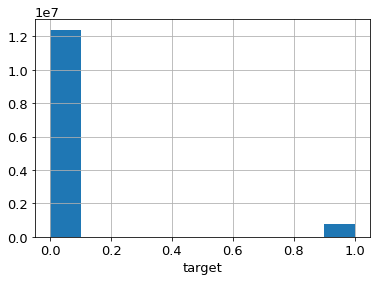

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.9018442711434008


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

     |████████████████████████████████| 258 kB 22.4 MB/s 
     |████████████████████████████████| 1.8 MB 54.1 MB/s 
     |████████████████████████████████| 103 kB 73.4 MB/s 


In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'new_country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['new_country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('new_country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,address,city,state,zip,url,phone,categories,point_of_interest,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
50768,E_02ef4d9ef8aa33,beach,hermitage bay,st. john's,parish of saint john,nan,nan,nan,beaches,P_c528103c8646f3,...,3,0.166667,15,0.30112,2,7,17,0.882353,0.117647,0.285714


,id,name,address,city,state,zip,url,phone,categories,point_of_interest,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
4,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",nan,nan,nan,nan,nan,nan,stadiums,TEST,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['new_country_pair'] = train[['new_country', 'near_new_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['new_country_pair'] = test[['new_country', 'near_new_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'new_country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['new_country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_new_country_gesh', 'near_new_country_jaro', 'near_new_country_lcs', 'near_new_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categor

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "new_country_pair"]]
test = test[features + ["id", "near_id", "new_country_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13171734 entries, 0 to 13171733
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["new_country_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "new_country_pair"], train.loc[val_ind, "new_country_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,94.19%,5.81%
development set - fold 0,94.09%,5.91%
validation set - fold 0,94.37%,5.63%
development set - fold 1,94.21%,5.79%
validation set - fold 1,94.15%,5.85%
development set - fold 2,94.26%,5.74%
validation set - fold 2,94.04%,5.96%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0719439

== fold 1 ==
[50]	valid_0's binary_logloss: 0.081658
[100]	valid_0's binary_logloss: 0.0800796
[150]	valid_0's binary_logloss: 0.0794723
[200]	valid_0's binary_logloss: 0.0791155
[250]	valid_0's binary_logloss: 0.0787563
[300]	valid_0's binary_logloss: 0.0785459
[350]	valid_0's binary_logloss: 0.078403
[400]	valid_0's binary_logloss: 0.0782384

== fold 2 ==
[50]	valid_0's binary_logloss: 0.0872725
[100]	valid_0's binary_logloss: 0.0852905
[150]	valid_0's binary_logloss: 0.0842738
[200]	valid_0's binary_logloss: 0.0837654
[250]	valid_0's binary_logloss: 0.0833945
[300]	valid_0's binary_logloss: 0.083125
[350]	valid_0's binary_logloss: 0.0829594
[400]	valid_0's binary_logloss: 0.0828654
[450]	valid_0's binary_logloss: 0.0827136

CV-accuracy: 0.9705051741858741


In [ ]:
train["pred"] = oof[:, -1]

# Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 23.8 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 210 kB 66.6 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 146 kB 44.2 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 61.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5216688c09c58ed606e92b5de3f67c57d25e2ea6a990c919715c9689586425b7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 16:10:50,778] A new study created in memory with name: no-name-215f3682-af4e-49c0-a45c-a35cf101f8cd
[I 2022-05-13 16:11:13,041] Trial 0 finished with value: 0.8078435171531725 and parameters: {'threshold': 0.5056624204844319}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807844, precision: 0.957543, recall: 0.843713


[I 2022-05-13 16:11:31,211] Trial 1 finished with value: 0.795173055394945 and parameters: {'threshold': 0.760398293286512}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.795173, precision: 0.984209, recall: 0.808448


[I 2022-05-13 16:11:49,756] Trial 2 finished with value: 0.7987834161453096 and parameters: {'threshold': 0.7256188362683664}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.798783, precision: 0.981179, recall: 0.814579


[I 2022-05-13 16:12:09,667] Trial 3 finished with value: 0.7995076007526667 and parameters: {'threshold': 0.7171807436601814}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.799508, precision: 0.980342, recall: 0.815954


[I 2022-05-13 16:12:37,886] Trial 4 finished with value: 0.7658802050333797 and parameters: {'threshold': 0.1340341467165913}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.765880, precision: 0.865748, recall: 0.880021


[I 2022-05-13 16:13:02,391] Trial 5 finished with value: 0.800612095164286 and parameters: {'threshold': 0.3104032279030968}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.800612, precision: 0.926994, recall: 0.862975


[I 2022-05-13 16:13:22,761] Trial 6 finished with value: 0.801062855621068 and parameters: {'threshold': 0.6976503740951019}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.801063, precision: 0.978416, recall: 0.819071


[I 2022-05-13 16:13:48,564] Trial 7 finished with value: 0.776963470322115 and parameters: {'threshold': 0.16645400231975016}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.776963, precision: 0.883006, recall: 0.876620


[I 2022-05-13 16:14:09,405] Trial 8 finished with value: 0.8077294685174068 and parameters: {'threshold': 0.5203403616611428}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807729, precision: 0.959293, recall: 0.842070


[I 2022-05-13 16:14:30,581] Trial 9 finished with value: 0.8078228976675689 and parameters: {'threshold': 0.5083212041294738}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807823, precision: 0.957872, recall: 0.843409


[I 2022-05-13 16:14:54,359] Trial 10 finished with value: 0.803210555581943 and parameters: {'threshold': 0.34567832933517373}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.803211, precision: 0.933889, recall: 0.859666


[I 2022-05-13 16:15:03,542] Trial 11 finished with value: 0.6744180148020171 and parameters: {'threshold': 0.9896950344389763}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.674418, precision: 0.999804, recall: 0.674568


[I 2022-05-13 16:15:24,500] Trial 12 finished with value: 0.80779761041622 and parameters: {'threshold': 0.5109859062425606}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807798, precision: 0.958184, recall: 0.843113


[I 2022-05-13 16:15:47,115] Trial 13 finished with value: 0.8034258886865339 and parameters: {'threshold': 0.3495462317564587}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.803426, precision: 0.934573, recall: 0.859288


[I 2022-05-13 16:16:07,380] Trial 14 finished with value: 0.8070808013340522 and parameters: {'threshold': 0.5711554875824727}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807081, precision: 0.965246, recall: 0.836237


[I 2022-05-13 16:16:29,310] Trial 15 finished with value: 0.8066871238489073 and parameters: {'threshold': 0.4217445672904731}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806687, precision: 0.946259, recall: 0.852425


[I 2022-05-13 16:16:45,299] Trial 16 finished with value: 0.7696127213095575 and parameters: {'threshold': 0.8849688453175297}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.769613, precision: 0.993596, recall: 0.774919


[I 2022-05-13 16:17:05,214] Trial 17 finished with value: 0.8059627104440373 and parameters: {'threshold': 0.6078638609753565}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.805963, precision: 0.969214, recall: 0.831696


[I 2022-05-13 16:17:35,784] Trial 18 finished with value: 0.6892072611471081 and parameters: {'threshold': 0.043509448349671076}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.689207, precision: 0.760230, recall: 0.891407


[I 2022-05-13 16:18:00,268] Trial 19 finished with value: 0.7893500418887156 and parameters: {'threshold': 0.22141524207648894}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.789350, precision: 0.903969, recall: 0.871266


[I 2022-05-13 16:18:22,091] Trial 20 finished with value: 0.806863603598224 and parameters: {'threshold': 0.42973109000882387}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806864, precision: 0.947405, recall: 0.851595


[I 2022-05-13 16:18:44,470] Trial 21 finished with value: 0.8077077535196975 and parameters: {'threshold': 0.4716980547508309}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807708, precision: 0.953187, recall: 0.847369


[I 2022-05-13 16:19:03,281] Trial 22 finished with value: 0.8050796576184618 and parameters: {'threshold': 0.6302007124128596}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.805080, precision: 0.971547, recall: 0.828813


[I 2022-05-13 16:19:25,055] Trial 23 finished with value: 0.8075897414900579 and parameters: {'threshold': 0.5386350710151366}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807590, precision: 0.961491, recall: 0.840015


[I 2022-05-13 16:19:46,874] Trial 24 finished with value: 0.8066410216385107 and parameters: {'threshold': 0.42039622965718115}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806641, precision: 0.946064, recall: 0.852550


[I 2022-05-13 16:20:04,521] Trial 25 finished with value: 0.7873327964053599 and parameters: {'threshold': 0.8144770282085989}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.787333, precision: 0.988444, recall: 0.796981


[I 2022-05-13 16:20:24,093] Trial 26 finished with value: 0.8044699093301259 and parameters: {'threshold': 0.6424385367104746}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.804470, precision: 0.972831, recall: 0.827120


[I 2022-05-13 16:20:48,103] Trial 27 finished with value: 0.7939607956165943 and parameters: {'threshold': 0.25100154123069646}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.793961, precision: 0.912698, recall: 0.868488


[I 2022-05-13 16:21:09,682] Trial 28 finished with value: 0.8077635348440938 and parameters: {'threshold': 0.4780743955923091}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807764, precision: 0.954043, recall: 0.846684


[I 2022-05-13 16:21:27,798] Trial 29 finished with value: 0.7917306040398165 and parameters: {'threshold': 0.7865516057815758}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.791731, precision: 0.986267, recall: 0.803243


[I 2022-05-13 16:21:48,575] Trial 30 finished with value: 0.8073671342039098 and parameters: {'threshold': 0.5546347474385391}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807367, precision: 0.963366, recall: 0.838160


[I 2022-05-13 16:22:09,899] Trial 31 finished with value: 0.8077630608758943 and parameters: {'threshold': 0.4785169962066093}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807763, precision: 0.954101, recall: 0.846633


[I 2022-05-13 16:22:32,315] Trial 32 finished with value: 0.8045114194982766 and parameters: {'threshold': 0.3678810126562736}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.804511, precision: 0.937832, recall: 0.857579


[I 2022-05-13 16:22:53,886] Trial 33 finished with value: 0.8077549529227809 and parameters: {'threshold': 0.47887251162075267}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807755, precision: 0.954139, recall: 0.846591


[I 2022-05-13 16:23:13,132] Trial 34 finished with value: 0.8028728075090998 and parameters: {'threshold': 0.6708309811228212}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.802873, precision: 0.975729, recall: 0.823098


[I 2022-05-13 16:23:33,150] Trial 35 finished with value: 0.8064913040805066 and parameters: {'threshold': 0.5939601392708568}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806491, precision: 0.967755, recall: 0.833482


[I 2022-05-13 16:23:57,464] Trial 36 finished with value: 0.7987642681878276 and parameters: {'threshold': 0.29121572723687417}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.798764, precision: 0.922786, recall: 0.864725


[I 2022-05-13 16:24:16,157] Trial 37 finished with value: 0.7976161442421942 and parameters: {'threshold': 0.7379952568074181}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.797616, precision: 0.982353, recall: 0.812460


[I 2022-05-13 16:24:38,200] Trial 38 finished with value: 0.8064523123761295 and parameters: {'threshold': 0.41469074126578154}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806452, precision: 0.945215, recall: 0.853091


[I 2022-05-13 16:24:59,264] Trial 39 finished with value: 0.8078276383164719 and parameters: {'threshold': 0.49712593721715564}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807828, precision: 0.956463, recall: 0.844641


[I 2022-05-13 16:25:20,338] Trial 40 finished with value: 0.8078207571819065 and parameters: {'threshold': 0.508882068258934}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807821, precision: 0.957947, recall: 0.843343


[I 2022-05-13 16:25:41,263] Trial 41 finished with value: 0.8077090043262682 and parameters: {'threshold': 0.5269574652246065}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807709, precision: 0.960093, recall: 0.841353


[I 2022-05-13 16:26:00,281] Trial 42 finished with value: 0.8026575933520976 and parameters: {'threshold': 0.6737444700292776}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.802658, precision: 0.976006, recall: 0.822650


[I 2022-05-13 16:26:20,615] Trial 43 finished with value: 0.8071995713278738 and parameters: {'threshold': 0.5658234977617683}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807200, precision: 0.964636, recall: 0.836883


[I 2022-05-13 16:26:44,108] Trial 44 finished with value: 0.8045299742945639 and parameters: {'threshold': 0.36835742504466784}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.804530, precision: 0.937904, recall: 0.857535


[I 2022-05-13 16:27:06,012] Trial 45 finished with value: 0.8071477906434111 and parameters: {'threshold': 0.44297316629448263}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807148, precision: 0.949257, recall: 0.850254


[I 2022-05-13 16:27:26,866] Trial 46 finished with value: 0.8077295461575947 and parameters: {'threshold': 0.5231026283405957}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807730, precision: 0.959648, recall: 0.841763


[I 2022-05-13 16:27:49,171] Trial 47 finished with value: 0.8056166350553514 and parameters: {'threshold': 0.39166626079411254}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.805617, precision: 0.941702, recall: 0.855314


[I 2022-05-13 16:28:12,421] Trial 48 finished with value: 0.8007589384411272 and parameters: {'threshold': 0.31203303004323724}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.800759, precision: 0.927343, recall: 0.862822


[I 2022-05-13 16:28:32,226] Trial 49 finished with value: 0.8060016413354961 and parameters: {'threshold': 0.606733554272759}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806002, precision: 0.969096, recall: 0.831834


[I 2022-05-13 16:28:53,073] Trial 50 finished with value: 0.807749847089888 and parameters: {'threshold': 0.5173003321169781}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807750, precision: 0.958931, recall: 0.842410


[I 2022-05-13 16:29:14,645] Trial 51 finished with value: 0.807746182560391 and parameters: {'threshold': 0.4769237287251291}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807746, precision: 0.953883, recall: 0.846806


[I 2022-05-13 16:29:36,078] Trial 52 finished with value: 0.8074111391365884 and parameters: {'threshold': 0.4555633168408663}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807411, precision: 0.951024, recall: 0.848963


[I 2022-05-13 16:29:56,859] Trial 53 finished with value: 0.8068640791404394 and parameters: {'threshold': 0.5811529216721343}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.806864, precision: 0.966334, recall: 0.835089


[I 2022-05-13 16:30:18,182] Trial 54 finished with value: 0.8077974791382604 and parameters: {'threshold': 0.5111954861477664}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807797, precision: 0.958207, recall: 0.843092


[I 2022-05-13 16:30:39,249] Trial 55 finished with value: 0.8077546050941999 and parameters: {'threshold': 0.5162889766758065}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807755, precision: 0.958813, recall: 0.842520


[I 2022-05-13 16:30:58,898] Trial 56 finished with value: 0.8047496564449691 and parameters: {'threshold': 0.6368301440491321}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.804750, precision: 0.972241, recall: 0.827895


[I 2022-05-13 16:31:21,257] Trial 57 finished with value: 0.8057666904955993 and parameters: {'threshold': 0.39563952819502646}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.805767, precision: 0.942307, recall: 0.854929


[I 2022-05-13 16:31:41,699] Trial 58 finished with value: 0.8073212604532033 and parameters: {'threshold': 0.5582610728804533}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807321, precision: 0.963786, recall: 0.837750


[I 2022-05-13 16:32:00,460] Trial 59 finished with value: 0.8011949056550299 and parameters: {'threshold': 0.6959432757987589}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.801195, precision: 0.978246, recall: 0.819339


[I 2022-05-13 16:32:23,484] Trial 60 finished with value: 0.8011487407168818 and parameters: {'threshold': 0.3163663223432556}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.801149, precision: 0.928264, recall: 0.862421


[I 2022-05-13 16:32:45,595] Trial 61 finished with value: 0.8078253290018179 and parameters: {'threshold': 0.4968057370985353}. Best is trial 0 with value: 0.8078435171531725.


CV: 0.807825, precision: 0.956420, recall: 0.844676


[I 2022-05-13 16:33:06,759] Trial 62 finished with value: 0.8078569427132638 and parameters: {'threshold': 0.5005885625046805}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807857, precision: 0.956922, recall: 0.844271


[I 2022-05-13 16:33:28,558] Trial 63 finished with value: 0.8071164550735873 and parameters: {'threshold': 0.44137657672449965}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807116, precision: 0.949029, recall: 0.850418


[I 2022-05-13 16:33:49,742] Trial 64 finished with value: 0.8078253215164022 and parameters: {'threshold': 0.4911331748683166}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807825, precision: 0.955697, recall: 0.845297


[I 2022-05-13 16:34:10,895] Trial 65 finished with value: 0.8078092581821056 and parameters: {'threshold': 0.49446356205541714}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807809, precision: 0.956122, recall: 0.844917


[I 2022-05-13 16:34:31,457] Trial 66 finished with value: 0.8074519707363358 and parameters: {'threshold': 0.5498327601554572}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807452, precision: 0.962823, recall: 0.838710


[I 2022-05-13 16:34:53,585] Trial 67 finished with value: 0.8062517992572086 and parameters: {'threshold': 0.40806437575346755}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.806252, precision: 0.944226, recall: 0.853745


[I 2022-05-13 16:35:13,594] Trial 68 finished with value: 0.8059744711581286 and parameters: {'threshold': 0.607479358605806}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.805974, precision: 0.969173, recall: 0.831742


[I 2022-05-13 16:35:23,174] Trial 69 finished with value: 0.6784475305158021 and parameters: {'threshold': 0.9880309610204683}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.678448, precision: 0.999755, recall: 0.678637


[I 2022-05-13 16:35:44,833] Trial 70 finished with value: 0.8074037547136649 and parameters: {'threshold': 0.455325490543172}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807404, precision: 0.950990, recall: 0.848985


[I 2022-05-13 16:36:07,003] Trial 71 finished with value: 0.8078176210311266 and parameters: {'threshold': 0.49240640131101265}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807818, precision: 0.955867, recall: 0.845150


[I 2022-05-13 16:36:28,150] Trial 72 finished with value: 0.8078195190271533 and parameters: {'threshold': 0.49621208328358646}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807820, precision: 0.956345, recall: 0.844733


[I 2022-05-13 16:36:48,314] Trial 73 finished with value: 0.8068041068785993 and parameters: {'threshold': 0.5835572895724351}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.806804, precision: 0.966611, recall: 0.834791


[I 2022-05-13 16:37:08,946] Trial 74 finished with value: 0.8075214426957446 and parameters: {'threshold': 0.5448172447995527}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807521, precision: 0.962231, recall: 0.839291


[I 2022-05-13 16:37:31,828] Trial 75 finished with value: 0.8029542790056919 and parameters: {'threshold': 0.3414724488243833}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.802954, precision: 0.933131, recall: 0.860054


[I 2022-05-13 16:37:53,394] Trial 76 finished with value: 0.80730848088816 and parameters: {'threshold': 0.4495003945047729}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807308, precision: 0.950188, recall: 0.849595


[I 2022-05-13 16:38:14,441] Trial 77 finished with value: 0.8078473585014011 and parameters: {'threshold': 0.5034250216361528}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807847, precision: 0.957275, recall: 0.843953


[I 2022-05-13 16:38:42,440] Trial 78 finished with value: 0.7401444246710565 and parameters: {'threshold': 0.08792801357351387}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.740144, precision: 0.828263, recall: 0.885379


[I 2022-05-13 16:39:01,745] Trial 79 finished with value: 0.8038736434500724 and parameters: {'threshold': 0.6534194872763065}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.803874, precision: 0.973942, recall: 0.825603


[I 2022-05-13 16:39:25,237] Trial 80 finished with value: 0.8043790657734529 and parameters: {'threshold': 0.36520661129979476}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.804379, precision: 0.937375, recall: 0.857841


[I 2022-05-13 16:39:46,360] Trial 81 finished with value: 0.8078196192653693 and parameters: {'threshold': 0.4934389279607263}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807820, precision: 0.955994, recall: 0.845041


[I 2022-05-13 16:40:08,203] Trial 82 finished with value: 0.8067292318426788 and parameters: {'threshold': 0.42291929822625807}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.806729, precision: 0.946435, recall: 0.852311


[I 2022-05-13 16:40:28,802] Trial 83 finished with value: 0.8076228544159809 and parameters: {'threshold': 0.5346021430742167}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807623, precision: 0.960995, recall: 0.840484


[I 2022-05-13 16:40:51,060] Trial 84 finished with value: 0.8076774993884874 and parameters: {'threshold': 0.4702192481123901}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807677, precision: 0.952990, recall: 0.847514


[I 2022-05-13 16:41:11,645] Trial 85 finished with value: 0.8070732329368154 and parameters: {'threshold': 0.57161758609647}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807073, precision: 0.965297, recall: 0.836184


[I 2022-05-13 16:41:34,082] Trial 86 finished with value: 0.8078485180357748 and parameters: {'threshold': 0.5012120247118451}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807849, precision: 0.956994, recall: 0.844199


[I 2022-05-13 16:41:56,449] Trial 87 finished with value: 0.8076158959686135 and parameters: {'threshold': 0.5366124651021287}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807616, precision: 0.961241, recall: 0.840261


[I 2022-05-13 16:42:20,205] Trial 88 finished with value: 0.8055546275977388 and parameters: {'threshold': 0.38977961290267293}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.805555, precision: 0.941411, recall: 0.855505


[I 2022-05-13 16:42:40,186] Trial 89 finished with value: 0.8054371958813903 and parameters: {'threshold': 0.6211934947900806}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.805437, precision: 0.970609, recall: 0.829972


[I 2022-05-13 16:43:01,479] Trial 90 finished with value: 0.8075825664136136 and parameters: {'threshold': 0.4628257458882362}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807583, precision: 0.952048, recall: 0.848251


[I 2022-05-13 16:43:24,095] Trial 91 finished with value: 0.8078228116443437 and parameters: {'threshold': 0.49673213417373757}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807823, precision: 0.956410, recall: 0.844683


[I 2022-05-13 16:43:45,214] Trial 92 finished with value: 0.807761202388992 and parameters: {'threshold': 0.5151861301430148}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807761, precision: 0.958683, recall: 0.842643


[I 2022-05-13 16:44:07,208] Trial 93 finished with value: 0.8068704973318096 and parameters: {'threshold': 0.42994602508684376}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.806870, precision: 0.947435, recall: 0.851575


[I 2022-05-13 16:44:27,620] Trial 94 finished with value: 0.8071378180236205 and parameters: {'threshold': 0.5681569577130784}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807138, precision: 0.964898, recall: 0.836595


[I 2022-05-13 16:44:48,561] Trial 95 finished with value: 0.8078411251963289 and parameters: {'threshold': 0.5053575145098808}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807841, precision: 0.957503, recall: 0.843747


[I 2022-05-13 16:45:09,689] Trial 96 finished with value: 0.8078267067145117 and parameters: {'threshold': 0.4913914517230923}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807827, precision: 0.955735, recall: 0.845267


[I 2022-05-13 16:45:31,042] Trial 97 finished with value: 0.8077091211892734 and parameters: {'threshold': 0.47236294471999246}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807709, precision: 0.953272, recall: 0.847295


[I 2022-05-13 16:45:50,874] Trial 98 finished with value: 0.8065455965682076 and parameters: {'threshold': 0.592667739531671}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.806546, precision: 0.967621, recall: 0.833651


[I 2022-05-13 16:46:11,569] Trial 99 finished with value: 0.8075723528088747 and parameters: {'threshold': 0.5406212131527898}. Best is trial 62 with value: 0.8078569427132638.


CV: 0.807572, precision: 0.961726, recall: 0.839789


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5005885625046805

In [ ]:
study.best_value

0.8078569427132638

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.807857, precision: 0.956922, recall: 0.844271


# Check Feature Importances

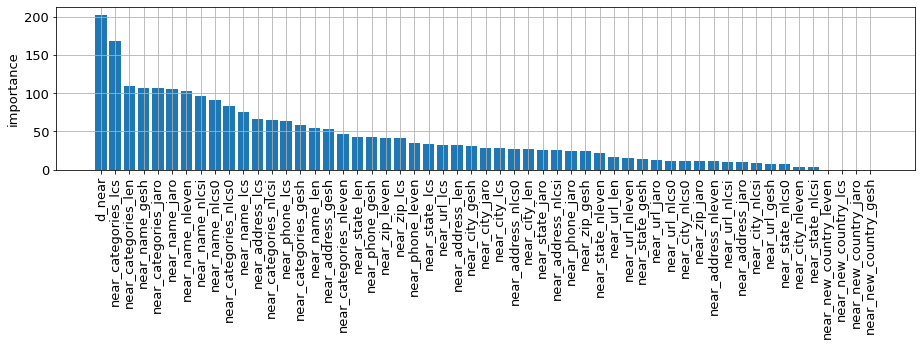

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[train["pred"] > x].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-13 16:46:34,376] A new study created in memory with name: no-name-2322c9b4-55dc-42ab-99e9-831a32e82a7a


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:48:09,710] Trial 0 finished with value: 0.8057907832095448 and parameters: {'threshold': 0.4288573209331019}. Best is trial 0 with value: 0.8057907832095448.


CV: 0.805791, precision: 0.941123, recall: 0.856020


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:49:44,342] Trial 1 finished with value: 0.8055908811586672 and parameters: {'threshold': 0.42402912241295854}. Best is trial 0 with value: 0.8057907832095448.


CV: 0.805591, precision: 0.940387, recall: 0.856464


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:50:59,297] Trial 2 finished with value: 0.8030498143408942 and parameters: {'threshold': 0.718678338736523}. Best is trial 0 with value: 0.8057907832095448.


CV: 0.803050, precision: 0.977079, recall: 0.822312


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:52:25,030] Trial 3 finished with value: 0.8081075815754991 and parameters: {'threshold': 0.5868286317045424}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.808108, precision: 0.962290, recall: 0.839852


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:54:11,506] Trial 4 finished with value: 0.780199504982414 and parameters: {'threshold': 0.20257549963983723}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.780200, precision: 0.887953, recall: 0.875742


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:55:07,063] Trial 5 finished with value: 0.718818003860307 and parameters: {'threshold': 0.9696243948550586}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.718818, precision: 0.998685, recall: 0.719881


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.649805, precision: 0.999999, recall: 0.649806


[I 2022-05-13 16:55:50,254] Trial 6 finished with value: 0.649804650226142 and parameters: {'threshold': 0.9998281505033554}. Best is trial 3 with value: 0.8081075815754991.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:57:42,616] Trial 7 finished with value: 0.7628545509218388 and parameters: {'threshold': 0.145504924282865}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.762855, precision: 0.860984, recall: 0.881056


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 16:59:24,486] Trial 8 finished with value: 0.7851823489976556 and parameters: {'threshold': 0.2260030907372842}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.785182, precision: 0.896225, recall: 0.873713


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.800804, precision: 0.980167, recall: 0.817561


[I 2022-05-13 17:00:35,201] Trial 9 finished with value: 0.8008038082881713 and parameters: {'threshold': 0.7482125116061645}. Best is trial 3 with value: 0.8081075815754991.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:01:50,747] Trial 10 finished with value: 0.8070945644521103 and parameters: {'threshold': 0.6344644144801831}. Best is trial 3 with value: 0.8081075815754991.


CV: 0.807095, precision: 0.967708, recall: 0.834147


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.806850, precision: 0.968516, recall: 0.833227


[I 2022-05-13 17:03:06,596] Trial 11 finished with value: 0.8068498013782442 and parameters: {'threshold': 0.6417362985378131}. Best is trial 3 with value: 0.8081075815754991.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:04:33,071] Trial 12 finished with value: 0.8081794936397936 and parameters: {'threshold': 0.5291516631828949}. Best is trial 12 with value: 0.8081794936397936.


CV: 0.808179, precision: 0.955142, recall: 0.846144


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:05:57,941] Trial 13 finished with value: 0.8081991789622773 and parameters: {'threshold': 0.5328716631616491}. Best is trial 13 with value: 0.8081991789622773.


CV: 0.808199, precision: 0.955621, recall: 0.845744


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.798516, precision: 0.921487, recall: 0.865620


[I 2022-05-13 17:07:36,352] Trial 14 finished with value: 0.7985160614314696 and parameters: {'threshold': 0.32014959541189475}. Best is trial 13 with value: 0.8081991789622773.


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.793199, precision: 0.985867, recall: 0.805055


[I 2022-05-13 17:08:46,550] Trial 15 finished with value: 0.7931988055995847 and parameters: {'threshold': 0.8119779471530203}. Best is trial 13 with value: 0.8081991789622773.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:10:16,886] Trial 16 finished with value: 0.80780459001181 and parameters: {'threshold': 0.49636592175968397}. Best is trial 13 with value: 0.8081991789622773.


CV: 0.807805, precision: 0.950827, recall: 0.849535


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:12:44,488] Trial 17 finished with value: 0.5884494633712661 and parameters: {'threshold': 0.017638954158500864}. Best is trial 13 with value: 0.8081991789622773.


CV: 0.588449, precision: 0.636454, recall: 0.896734


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:14:17,552] Trial 18 finished with value: 0.8007128864022941 and parameters: {'threshold': 0.3448978261440328}. Best is trial 13 with value: 0.8081991789622773.


CV: 0.800713, precision: 0.926606, recall: 0.863451


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:15:45,357] Trial 19 finished with value: 0.8082001961107462 and parameters: {'threshold': 0.5328105094338048}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.808200, precision: 0.955613, recall: 0.845750


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:16:55,100] Trial 20 finished with value: 0.7863071887637906 and parameters: {'threshold': 0.8500783845234064}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.786307, precision: 0.989103, recall: 0.795402


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:18:20,782] Trial 21 finished with value: 0.8081862694271511 and parameters: {'threshold': 0.5312018809774831}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.808186, precision: 0.955403, recall: 0.845922


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:19:48,123] Trial 22 finished with value: 0.8079198941001637 and parameters: {'threshold': 0.5005118922382237}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.807920, precision: 0.951421, recall: 0.849135


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.804154, precision: 0.935807, recall: 0.858983


[I 2022-05-13 17:21:25,638] Trial 23 finished with value: 0.8041543911515272 and parameters: {'threshold': 0.3956164149458927}. Best is trial 19 with value: 0.8082001961107462.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:22:47,149] Trial 24 finished with value: 0.8080665007743202 and parameters: {'threshold': 0.5909222913964071}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.808067, precision: 0.962784, recall: 0.839377


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:24:15,845] Trial 25 finished with value: 0.8081646620410106 and parameters: {'threshold': 0.5229129531668462}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.808165, precision: 0.954373, recall: 0.846810


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:25:24,723] Trial 26 finished with value: 0.8028677112993012 and parameters: {'threshold': 0.7214737010213967}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.802868, precision: 0.977373, recall: 0.821890


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:26:55,219] Trial 27 finished with value: 0.8002186948227583 and parameters: {'threshold': 0.33911903190367765}. Best is trial 19 with value: 0.8082001961107462.


CV: 0.800219, precision: 0.925445, recall: 0.863940


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.806382, precision: 0.969866, recall: 0.831638


[I 2022-05-13 17:28:12,346] Trial 28 finished with value: 0.8063819043420192 and parameters: {'threshold': 0.6536527015911026}. Best is trial 19 with value: 0.8082001961107462.


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.804958, precision: 0.938298, recall: 0.857634


[I 2022-05-13 17:29:44,732] Trial 29 finished with value: 0.8049582218879293 and parameters: {'threshold': 0.4106044476717745}. Best is trial 19 with value: 0.8082001961107462.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:31:06,346] Trial 30 finished with value: 0.8083068377238908 and parameters: {'threshold': 0.5652924382770123}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808307, precision: 0.959726, recall: 0.842269


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.807169, precision: 0.947027, recall: 0.852211


[I 2022-05-13 17:32:35,497] Trial 31 finished with value: 0.8071688147004448 and parameters: {'threshold': 0.46904626407443023}. Best is trial 30 with value: 0.8083068377238908.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:33:56,884] Trial 32 finished with value: 0.8082907067198384 and parameters: {'threshold': 0.5668939337649217}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808291, precision: 0.959913, recall: 0.842094


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:35:18,574] Trial 33 finished with value: 0.808204538972088 and parameters: {'threshold': 0.5839232102548503}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808205, precision: 0.961977, recall: 0.840221


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:36:38,029] Trial 34 finished with value: 0.8080889207267282 and parameters: {'threshold': 0.5896980147730495}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808089, precision: 0.962648, recall: 0.839518


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:37:52,137] Trial 35 finished with value: 0.8056701878090142 and parameters: {'threshold': 0.6721227290601188}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.805670, precision: 0.971932, recall: 0.829187


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:39:06,106] Trial 36 finished with value: 0.7949676773886437 and parameters: {'threshold': 0.7994548726076888}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.794968, precision: 0.984774, recall: 0.807759


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:40:13,339] Trial 37 finished with value: 0.770342606343679 and parameters: {'threshold': 0.9024349527817429}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.770343, precision: 0.993577, recall: 0.775661


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.806027, precision: 0.942286, recall: 0.855226


[I 2022-05-13 17:41:44,927] Trial 38 finished with value: 0.8060269024367028 and parameters: {'threshold': 0.43708156756031746}. Best is trial 30 with value: 0.8083068377238908.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:43:06,614] Trial 39 finished with value: 0.8079117650906159 and parameters: {'threshold': 0.6002592322672712}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.807912, precision: 0.963844, recall: 0.838294


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:44:25,897] Trial 40 finished with value: 0.8047697164329881 and parameters: {'threshold': 0.6899024943775002}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.804770, precision: 0.973926, recall: 0.826628


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808289, precision: 0.959874, recall: 0.842127


[I 2022-05-13 17:45:53,993] Trial 41 finished with value: 0.808289099298541 and parameters: {'threshold': 0.5665491836093254}. Best is trial 30 with value: 0.8083068377238908.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:47:22,820] Trial 42 finished with value: 0.8082040888339007 and parameters: {'threshold': 0.5764597689626996}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808204, precision: 0.961053, recall: 0.841024


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.800213, precision: 0.980744, recall: 0.816487


[I 2022-05-13 17:48:37,262] Trial 43 finished with value: 0.8002129623270858 and parameters: {'threshold': 0.7541949817689806}. Best is trial 30 with value: 0.8083068377238908.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:50:05,794] Trial 44 finished with value: 0.8082188008393768 and parameters: {'threshold': 0.5768603824779394}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.808219, precision: 0.961109, recall: 0.840993


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:51:41,987] Trial 45 finished with value: 0.8067946107745018 and parameters: {'threshold': 0.4583469202458055}. Best is trial 30 with value: 0.8083068377238908.


CV: 0.806795, precision: 0.945489, recall: 0.853183


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.807338, precision: 0.966669, recall: 0.835274


[I 2022-05-13 17:53:07,989] Trial 46 finished with value: 0.8073381321220274 and parameters: {'threshold': 0.6253889476963855}. Best is trial 30 with value: 0.8083068377238908.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:54:33,723] Trial 47 finished with value: 0.8083107918674588 and parameters: {'threshold': 0.5637604855810249}. Best is trial 47 with value: 0.8083107918674588.


CV: 0.808311, precision: 0.959526, recall: 0.842444


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:55:51,098] Trial 48 finished with value: 0.8045079382497266 and parameters: {'threshold': 0.6954005089692507}. Best is trial 47 with value: 0.8083107918674588.


CV: 0.804508, precision: 0.974521, recall: 0.825862


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:57:33,937] Trial 49 finished with value: 0.7957152922190327 and parameters: {'threshold': 0.295021701500484}. Best is trial 47 with value: 0.8083107918674588.


CV: 0.795715, precision: 0.915704, recall: 0.867771


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 17:59:12,983] Trial 50 finished with value: 0.8043138516847057 and parameters: {'threshold': 0.39847040544739554}. Best is trial 47 with value: 0.8083107918674588.


CV: 0.804314, precision: 0.936293, recall: 0.858723


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:00:39,647] Trial 51 finished with value: 0.808322192303386 and parameters: {'threshold': 0.5627016643619087}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808322, precision: 0.959414, recall: 0.842553


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:02:11,739] Trial 52 finished with value: 0.8083184158724012 and parameters: {'threshold': 0.5626096930040078}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808318, precision: 0.959399, recall: 0.842562


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:03:45,306] Trial 53 finished with value: 0.8074782935620323 and parameters: {'threshold': 0.4824873945448475}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807478, precision: 0.948915, recall: 0.850872


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:05:13,517] Trial 54 finished with value: 0.8083130123375735 and parameters: {'threshold': 0.5515237318903619}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808313, precision: 0.958050, recall: 0.843734


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:06:33,849] Trial 55 finished with value: 0.8069656865209897 and parameters: {'threshold': 0.6379930008033997}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806966, precision: 0.968111, recall: 0.833682


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808255, precision: 0.956635, recall: 0.844915


[I 2022-05-13 18:08:06,271] Trial 56 finished with value: 0.8082549834797979 and parameters: {'threshold': 0.5405367354540933}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:09:28,698] Trial 57 finished with value: 0.8072967164564643 and parameters: {'threshold': 0.6289315457262892}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807297, precision: 0.967089, recall: 0.834872


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:11:05,227] Trial 58 finished with value: 0.8060840571981871 and parameters: {'threshold': 0.43907070390457076}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806084, precision: 0.942575, recall: 0.855022


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808015, precision: 0.952293, recall: 0.848476


[I 2022-05-13 18:12:38,744] Trial 59 finished with value: 0.808015310941308 and parameters: {'threshold': 0.5069865121416307}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:13:51,487] Trial 60 finished with value: 0.8025682613393192 and parameters: {'threshold': 0.726208802272954}. Best is trial 51 with value: 0.808322192303386.


CV: 0.802568, precision: 0.977873, recall: 0.821193


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:15:18,335] Trial 61 finished with value: 0.8082860264493337 and parameters: {'threshold': 0.557701204203409}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808286, precision: 0.958778, recall: 0.843073


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808295, precision: 0.958231, recall: 0.843561


[I 2022-05-13 18:16:47,386] Trial 62 finished with value: 0.8082953682228806 and parameters: {'threshold': 0.553140552745297}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:18:21,139] Trial 63 finished with value: 0.8074272454379676 and parameters: {'threshold': 0.4805604451864166}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807427, precision: 0.948657, recall: 0.851045


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.807710, precision: 0.965173, recall: 0.836939


[I 2022-05-13 18:19:46,659] Trial 64 finished with value: 0.8077100438303452 and parameters: {'threshold': 0.6117991283858986}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:21:05,902] Trial 65 finished with value: 0.8060246139065133 and parameters: {'threshold': 0.6637513126674995}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806025, precision: 0.970985, recall: 0.830337


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:22:42,940] Trial 66 finished with value: 0.8027168821855474 and parameters: {'threshold': 0.3728435039465386}. Best is trial 51 with value: 0.808322192303386.


CV: 0.802717, precision: 0.931847, recall: 0.860977


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:24:13,995] Trial 67 finished with value: 0.8082107124161324 and parameters: {'threshold': 0.5348051804284784}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808211, precision: 0.955864, recall: 0.845548


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808028, precision: 0.952754, recall: 0.848089


[I 2022-05-13 18:25:46,557] Trial 68 finished with value: 0.808028214971051 and parameters: {'threshold': 0.5105458969810466}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:27:17,085] Trial 69 finished with value: 0.8082928189214175 and parameters: {'threshold': 0.5579233618525805}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808293, precision: 0.958814, recall: 0.843049


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.807016, precision: 0.946299, recall: 0.852698


[I 2022-05-13 18:28:53,441] Trial 70 finished with value: 0.8070156201899885 and parameters: {'threshold': 0.46397921351426136}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:30:22,294] Trial 71 finished with value: 0.8083077912170492 and parameters: {'threshold': 0.5524791898025152}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808308, precision: 0.958161, recall: 0.843635


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808300, precision: 0.957601, recall: 0.844102


[I 2022-05-13 18:31:51,036] Trial 72 finished with value: 0.8082998074748549 and parameters: {'threshold': 0.548019057043345}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:33:16,776] Trial 73 finished with value: 0.8076952737448335 and parameters: {'threshold': 0.6120334843191435}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807695, precision: 0.965189, recall: 0.836912


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:34:51,623] Trial 74 finished with value: 0.8079002835604073 and parameters: {'threshold': 0.499736362585771}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807900, precision: 0.951308, recall: 0.849216


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.808297, precision: 0.957308, recall: 0.844360


[I 2022-05-13 18:36:18,742] Trial 75 finished with value: 0.8082966147741178 and parameters: {'threshold': 0.5457242253208006}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:37:54,274] Trial 76 finished with value: 0.806034434296256 and parameters: {'threshold': 0.4371698292511416}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806034, precision: 0.942305, recall: 0.855216


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.806446, precision: 0.969732, recall: 0.831813


[I 2022-05-13 18:39:11,320] Trial 77 finished with value: 0.8064461044805507 and parameters: {'threshold': 0.6523674105071826}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:40:29,469] Trial 78 finished with value: 0.80787589311003 and parameters: {'threshold': 0.6022144422940079}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807876, precision: 0.964078, recall: 0.838052


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:43:40,940] Trial 79 finished with value: 0.4282686453068216 and parameters: {'threshold': 0.0049991802574788635}. Best is trial 51 with value: 0.808322192303386.


CV: 0.428269, precision: 0.453599, recall: 0.900111


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:45:05,383] Trial 80 finished with value: 0.808252103781315 and parameters: {'threshold': 0.5412499626805433}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808252, precision: 0.956713, recall: 0.844843


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:46:38,770] Trial 81 finished with value: 0.8080527706442056 and parameters: {'threshold': 0.5135219790027228}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808053, precision: 0.953139, recall: 0.847776


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:48:06,434] Trial 82 finished with value: 0.8083098653048281 and parameters: {'threshold': 0.5622670030316729}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808310, precision: 0.959348, recall: 0.842596


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:49:32,350] Trial 83 finished with value: 0.808100492773324 and parameters: {'threshold': 0.5871070910187358}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808100, precision: 0.962321, recall: 0.839817


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.807408, precision: 0.948350, recall: 0.851296


[I 2022-05-13 18:51:09,221] Trial 84 finished with value: 0.8074079751816634 and parameters: {'threshold': 0.4782631366525977}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:52:39,402] Trial 85 finished with value: 0.8081687033108417 and parameters: {'threshold': 0.5279365501513277}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808169, precision: 0.954992, recall: 0.846269


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:54:38,215] Trial 86 finished with value: 0.7493611639154893 and parameters: {'threshold': 0.11687249092396901}. Best is trial 51 with value: 0.808322192303386.


CV: 0.749361, precision: 0.841312, recall: 0.883901


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:55:55,591] Trial 87 finished with value: 0.804174297067208 and parameters: {'threshold': 0.7007797788526314}. Best is trial 51 with value: 0.808322192303386.


CV: 0.804174, precision: 0.975058, recall: 0.825081


  0%|          | 0/13171734 [00:00<?, ?it/s]

CV: 0.805630, precision: 0.972021, recall: 0.829071


[I 2022-05-13 18:57:15,284] Trial 88 finished with value: 0.8056299964572602 and parameters: {'threshold': 0.6729993730593355}. Best is trial 51 with value: 0.808322192303386.


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 18:58:38,968] Trial 89 finished with value: 0.8075177041594371 and parameters: {'threshold': 0.618607878648607}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807518, precision: 0.965897, recall: 0.836115


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:00:09,293] Trial 90 finished with value: 0.808259301621657 and parameters: {'threshold': 0.572696636544834}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808259, precision: 0.960619, recall: 0.841446


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:01:37,474] Trial 91 finished with value: 0.8083149420231281 and parameters: {'threshold': 0.5642056444876526}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808315, precision: 0.959583, recall: 0.842397


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:03:06,602] Trial 92 finished with value: 0.8082812147070023 and parameters: {'threshold': 0.5559746381063927}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808281, precision: 0.958572, recall: 0.843251


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:04:38,986] Trial 93 finished with value: 0.8077348463609697 and parameters: {'threshold': 0.49298830941665484}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807735, precision: 0.950353, recall: 0.849875


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:06:15,112] Trial 94 finished with value: 0.8067098380834714 and parameters: {'threshold': 0.4553571600157071}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806710, precision: 0.945059, recall: 0.853476


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:07:38,908] Trial 95 finished with value: 0.8069115793009134 and parameters: {'threshold': 0.6396058072276118}. Best is trial 51 with value: 0.808322192303386.


CV: 0.806912, precision: 0.968283, recall: 0.833483


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:09:13,081] Trial 96 finished with value: 0.8080992774521548 and parameters: {'threshold': 0.5194606528146736}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808099, precision: 0.953886, recall: 0.847169


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:10:39,517] Trial 97 finished with value: 0.8081187111954142 and parameters: {'threshold': 0.5875833006793044}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808119, precision: 0.962392, recall: 0.839774


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:12:05,103] Trial 98 finished with value: 0.8078270134735334 and parameters: {'threshold': 0.6042562369280601}. Best is trial 51 with value: 0.808322192303386.


CV: 0.807827, precision: 0.964300, recall: 0.837812


  0%|          | 0/13171734 [00:00<?, ?it/s]

[I 2022-05-13 19:13:35,540] Trial 99 finished with value: 0.8083177292747841 and parameters: {'threshold': 0.5493071895697161}. Best is trial 51 with value: 0.808322192303386.


CV: 0.808318, precision: 0.957782, recall: 0.843967


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5627016643619087

In [ ]:
study.best_value

0.808322192303386

In [ ]:
id2ids = train[train["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[test["pred"] > threshold].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()